In [1]:
#!pip install evaluate peft==0.10.0 transformers==4.36.0 accelerate==0.28.0

import torch
import evaluate
import numpy as np
from itertools import chain
from collections import defaultdict
from torch.utils.data import Subset
from torchvision import datasets
from torchvision import transforms
from transformers import AutoImageProcessor
from transformers import ViTForImageClassification
from transformers import TrainingArguments, Trainer


def subset_sampler(dataset, classes, max_len):
    target_idx = defaultdict(list)
    for idx, label in enumerate(dataset.train_labels):
        target_idx[int(label)].append(idx)

    indices = list(
        chain.from_iterable(
            [target_idx[idx][:max_len] for idx in range(len(classes))]
        )
    )
    return Subset(dataset, indices)


def model_init(classes, class_to_idx):
    model = ViTForImageClassification.from_pretrained(
        pretrained_model_name_or_path="google/vit-base-patch16-224-in21k",
        num_labels=len(classes),
        id2label={idx: label for label, idx in class_to_idx.items()},
        label2id=class_to_idx,
    )
    return model


def collator(data, transform):
    images, labels = zip(*data)
    pixel_values = torch.stack([transform(image) for image in images])
    labels = torch.tensor([label for label in labels])
    return {"pixel_values": pixel_values, "labels": labels}


def compute_metrics(eval_pred):
    metric = evaluate.load("f1")
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    macro_f1 = metric.compute(
        predictions=predictions, references=labels, average="macro"
    )
    return macro_f1


train_dataset = datasets.FashionMNIST(root="./datasets", download=True, train=True)
test_dataset = datasets.FashionMNIST(root="./datasets", download=True, train=False)

classes = train_dataset.classes
class_to_idx = train_dataset.class_to_idx

subset_train_dataset = subset_sampler(
    dataset=train_dataset, classes=train_dataset.classes, max_len=1000
)
subset_test_dataset = subset_sampler(
    dataset=test_dataset, classes=test_dataset.classes, max_len=100
)

image_processor = AutoImageProcessor.from_pretrained(
    pretrained_model_name_or_path="google/vit-base-patch16-224-in21k"
)

transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Resize(
            size=(
                image_processor.size["height"],
                image_processor.size["width"]
            )
        ),
        transforms.Lambda(
            lambda x: torch.cat([x, x, x], 0)
        ),
        transforms.Normalize(
            mean=image_processor.image_mean,
            std=image_processor.image_std
        )
    ]
)

args = TrainingArguments(
    output_dir="./models/ViT-FashionMNIST",
    save_strategy="epoch",
    evaluation_strategy="epoch",
    learning_rate=1e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.001,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    logging_dir="logs",
    logging_steps=125,
    remove_unused_columns=False,
    seed=7
)

trainer = Trainer(
    model_init=lambda x: model_init(classes, class_to_idx),
    args=args,
    train_dataset=subset_train_dataset,
    eval_dataset=subset_test_dataset,
    data_collator=lambda x: collator(x, transform),
    compute_metrics=compute_metrics,
    tokenizer=image_processor,
)
trainer.train()

/home/chohi/PythonProject5/.venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/chohi/PythonProject5/.venv/lib/python3.9/site-packages/transformers/utils/generic.py:441: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
2025-06-02 14:10:42.476830: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-06-02 14:10:42.489654: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin c

Epoch,Training Loss,Validation Loss,F1
1,0.694100,0.652391,0.867249
2,0.472400,0.469374,0.914395
3,0.406500,0.425678,0.923036


Checkpoint destination directory ./models/ViT-FashionMNIST/checkpoint-625 already exists and is non-empty.Saving will proceed but saved results may be invalid.
Checkpoint destination directory ./models/ViT-FashionMNIST/checkpoint-1250 already exists and is non-empty.Saving will proceed but saved results may be invalid.
Checkpoint destination directory ./models/ViT-FashionMNIST/checkpoint-1875 already exists and is non-empty.Saving will proceed but saved results may be invalid.


TrainOutput(global_step=1875, training_loss=0.6996439005533854, metrics={'train_runtime': 391.0508, 'train_samples_per_second': 76.716, 'train_steps_per_second': 4.795, 'total_flos': 2.32492637712384e+18, 'train_loss': 0.6996439005533854, 'epoch': 3.0})

PredictionOutput(predictions=array([[ 3.0994186 , -0.5652571 , -0.3347855 , ..., -0.4598486 ,
        -0.32700774, -0.6048753 ],
       [ 1.9599935 , -0.6994511 , -0.33981097, ..., -0.7219098 ,
        -0.7356377 , -0.8154605 ],
       [ 2.9799216 , -0.5585234 , -0.16116676, ..., -0.53711057,
        -0.33613405, -0.661896  ],
       ...,
       [-0.53881806, -0.692718  , -0.6540822 , ...,  0.9527682 ,
         0.4470103 ,  2.687696  ],
       [-0.6105169 , -0.4035847 , -0.35239798, ...,  0.26184422,
        -0.28473604,  3.3945038 ],
       [-0.4766033 , -0.37096357, -0.2813762 , ..., -0.20677826,
        -0.23501451,  3.40108   ]], dtype=float32), label_ids=array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

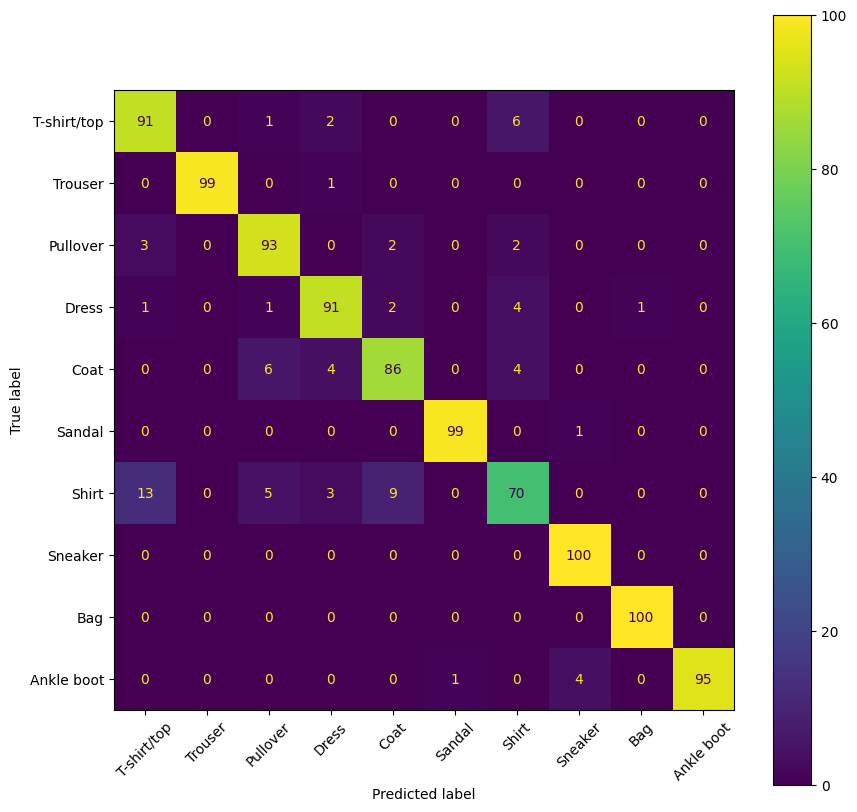

In [2]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


outputs = trainer.predict(subset_test_dataset)
print(outputs)

y_true = outputs.label_ids
y_pred = outputs.predictions.argmax(1)

labels = list(classes)
matrix = confusion_matrix(y_true, y_pred)
display = ConfusionMatrixDisplay(confusion_matrix=matrix, display_labels=labels)
_, ax = plt.subplots(figsize=(10, 10))
display.plot(xticks_rotation=45, ax=ax)
plt.show()